In [1]:
import os
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import List, Dict
from tqdm import tqdm
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

2025-02-13 08:34:08.127835: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 08:34:08.175273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 08:34:08.282004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 08:34:09.141472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Set the cache directory to a folder in your home directory

In [2]:

os.environ['TRANSFORMERS_CACHE'] = os.path.expanduser('~/huggingface_cache')
# Create the folder if it doesn't exist
os.makedirs(os.path.expanduser('~/huggingface_cache'), exist_ok=True)

In [3]:
def load_and_preprocess_csv(file_path: str) -> pd.DataFrame:
    """
    Load and preprocess a CSV file.
    
    This function loads the CSV file from the given path, prints the first 10 rows
    so you can verify that the data and columns match what was used in the files,
    and returns the DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        print("CSV file loaded successfully.")
        print("\nFirst 10 rows of the data:")
        print(df.head(10))
        return df
    except Exception as e:
        raise ValueError(f"Error loading CSV file: {e}")

# Emotion Analysis Class
class ConversationEmotionAnalyzer:
    def __init__(self, df: pd.DataFrame):
        """Initialize analyzer with loaded DataFrame."""
        self.df = df
        
        # Initialize EmoRoBERTa using the Hugging Face pipeline.
        self.emotion_classifier = pipeline(
            "text-classification",
            model="arpanghoshal/EmoRoBERTa",
            model_kwargs={"from_tf": True},
            truncation=True,
            max_length=512
        )
        
        # Patterns for identifying apologies
        self.apology_patterns = [
            r'(?i)sorry', r'(?i)apologize', r'(?i)regret',
            r'(?i)apologies', r'(?i)my mistake', r'(?i)incorrect'
        ]

    def analyze_emotion(self, text: str) -> Dict:
        """Analyze text emotion using EmoRoBERTa."""
        try:
            result = self.emotion_classifier(str(text))[0]
            return {
                'emotion': result['label'],
                'confidence': result['score']
            }
        except Exception as e:
            print(f"Error in emotion analysis: {e}")
            return {'emotion': 'unknown', 'confidence': 0.0}

    def calculate_similarity(self, responses: List[str]) -> float:
        """
        Calculate similarity between consecutive system responses.
        This version filters out responses that are not valid strings
        and catches errors related to an empty vocabulary.
        """
        # Filter out responses that are not strings, are NaN, or empty after stripping
        valid_responses = [r.strip() for r in responses 
                           if isinstance(r, str) and pd.notnull(r) and r.strip() != '']
        
        if len(valid_responses) < 2:
            return 0.0
            
        vectorizer = TfidfVectorizer()
        try:
            tfidf_matrix = vectorizer.fit_transform(valid_responses)
            similarities = cosine_similarity(tfidf_matrix)
            # Calculate mean similarity between each consecutive pair
            return np.mean([similarities[i, i+1] for i in range(len(similarities)-1)])
        except ValueError as e:
            # This error occurs if the vocabulary is empty (e.g., if documents only contain stop words)
            print(f"Error calculating similarity: {e}")
            return 0.0

    def analyze_conversations(self, similarity_threshold: float = 0.7):
        """
        Analyze conversations for emotional progression and response patterns.
        Uses 'user_prompt' for user messages and 'sys_response' for system responses.
        """
        analyzed_conversations = []
        
        # Group the DataFrame by conversation_id
        for conv_id, conv_group in tqdm(self.df.groupby('conversation_id'),
                                          desc="Analyzing conversations"):
            user_messages = conv_group['user_prompt'].tolist()
            system_responses = conv_group['sys_response'].tolist()
            
            # Skip if fewer than 2 user messages exist
            if len(user_messages) < 2:
                continue
            
            # Analyze emotional progression for user messages
            emotions = []
            for msg in user_messages:
                emotion_data = self.analyze_emotion(msg)
                emotions.append(emotion_data)
            
            # Identify negative emotions
            negative_emotions = ['anger', 'sadness', 'disgust', 'fear']
            negative_progression = [e['emotion'] in negative_emotions for e in emotions]
            
            if any(negative_progression):
                if len(system_responses) >= 2:
                    similarity = self.calculate_similarity(system_responses)
                    
                    if similarity >= similarity_threshold:
                        analyzed_conversations.append({
                            'conversation_id': conv_id,
                            'messages': user_messages,
                            'responses': system_responses,
                            'emotions': emotions,
                            'response_similarity': similarity,
                            'contains_apology': any(
                                any(re.search(p, r) for p in self.apology_patterns)
                                for r in system_responses if isinstance(r, str)
                            ),
                            'negative_count': sum(negative_progression)
                        })
        
        return analyzed_conversations

    def generate_analysis_report(self, conversations):
        """Generate comprehensive visualizations for the analysis."""
        if not conversations:
            return "No conversations to analyze."
            
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Emotion Distribution
        plt.subplot(2, 2, 1)
        emotion_counts = {}
        for conv in conversations:
            for emotion_data in conv['emotions']:
                emotion = emotion_data['emotion']
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        plt.bar(list(emotion_counts.keys()), list(emotion_counts.values()))
        plt.title('Distribution of Emotions')
        plt.xticks(rotation=45)
        
        # 2. Response Similarity vs Negative Emotions
        plt.subplot(2, 2, 2)
        similarities = [c['response_similarity'] for c in conversations]
        negative_counts = [c['negative_count'] for c in conversations]
        plt.scatter(similarities, negative_counts, alpha=0.5)
        plt.title('Response Similarity vs Negative Emotions')
        plt.xlabel('Response Similarity')
        plt.ylabel('Number of Negative Emotions')
        
        # 3. Emotional Progression Over Time (first 5 conversations)
        plt.subplot(2, 2, 3)
        for i, conv in enumerate(conversations[:5]):
            negative_flags = [e['emotion'] in ['anger', 'sadness', 'disgust', 'fear']
                              for e in conv['emotions']]
            plt.plot(range(len(negative_flags)),
                     np.cumsum(negative_flags),
                     label=f'Conv {i+1}')
        plt.title('Accumulation of Negative Emotions')
        plt.xlabel('Message Sequence')
        plt.ylabel('Cumulative Negative Emotions')
        plt.legend()
        
        # 4. System Apology Analysis
        plt.subplot(2, 2, 4)
        apology_data = [int(c['contains_apology']) for c in conversations]
        plt.hist(apology_data, bins=2)
        plt.title('Distribution of System Apologies')
        plt.xlabel('Contains Apology')
        plt.ylabel('Count')
        
        plt.tight_layout()
        return fig

Loading and processing CSV data...


CSV file loaded successfully.

First 10 rows of the data:
   conversation_id                             prompt_id  \
0                1  f2923bd2-55ed-40bf-a08a-d7d840310c83   
1                1  0e21dd95-ff1a-4c2a-9a19-d5bb638d4c8e   
2                1  e4d628bb-925b-4193-a721-2f9e297d8c3e   
3                1  1de9702f-445b-4ed2-be23-72d286b72e12   
4                1  fe913ed9-0348-4403-8d2d-d10298595e46   
5                3  896b89c3-f16e-4444-8f74-5f5986610264   
6                3  7c20568d-dad3-4df1-8c89-c46d7e8849e5   
7                3  fb7d704e-1e5a-4dac-ad7f-9b2e3734b0c5   
8                3  4580c376-28b9-44dc-bc93-69bd9883ab96   
9                3  18a57669-8258-43d4-b60a-1bb37517f32c   

                                         user_prompt  \
0  What goes in to a terms of reference for a mee...   
1  1. Purpose: familiarize both labs with researc...   
2  Help write this better: Purpose: familiarize b...   
3  Write these better:\nKnowledge sharing for ong...   
4

2025-02-13 08:35:14.917625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-13 08:35:14.919766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-13 08:35:14.921839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf


Analyzing conversations...


Analyzing conversations: 100%|██████████| 169404/169404 [7:06:11<00:00,  6.62it/s]   



Generating visualizations...


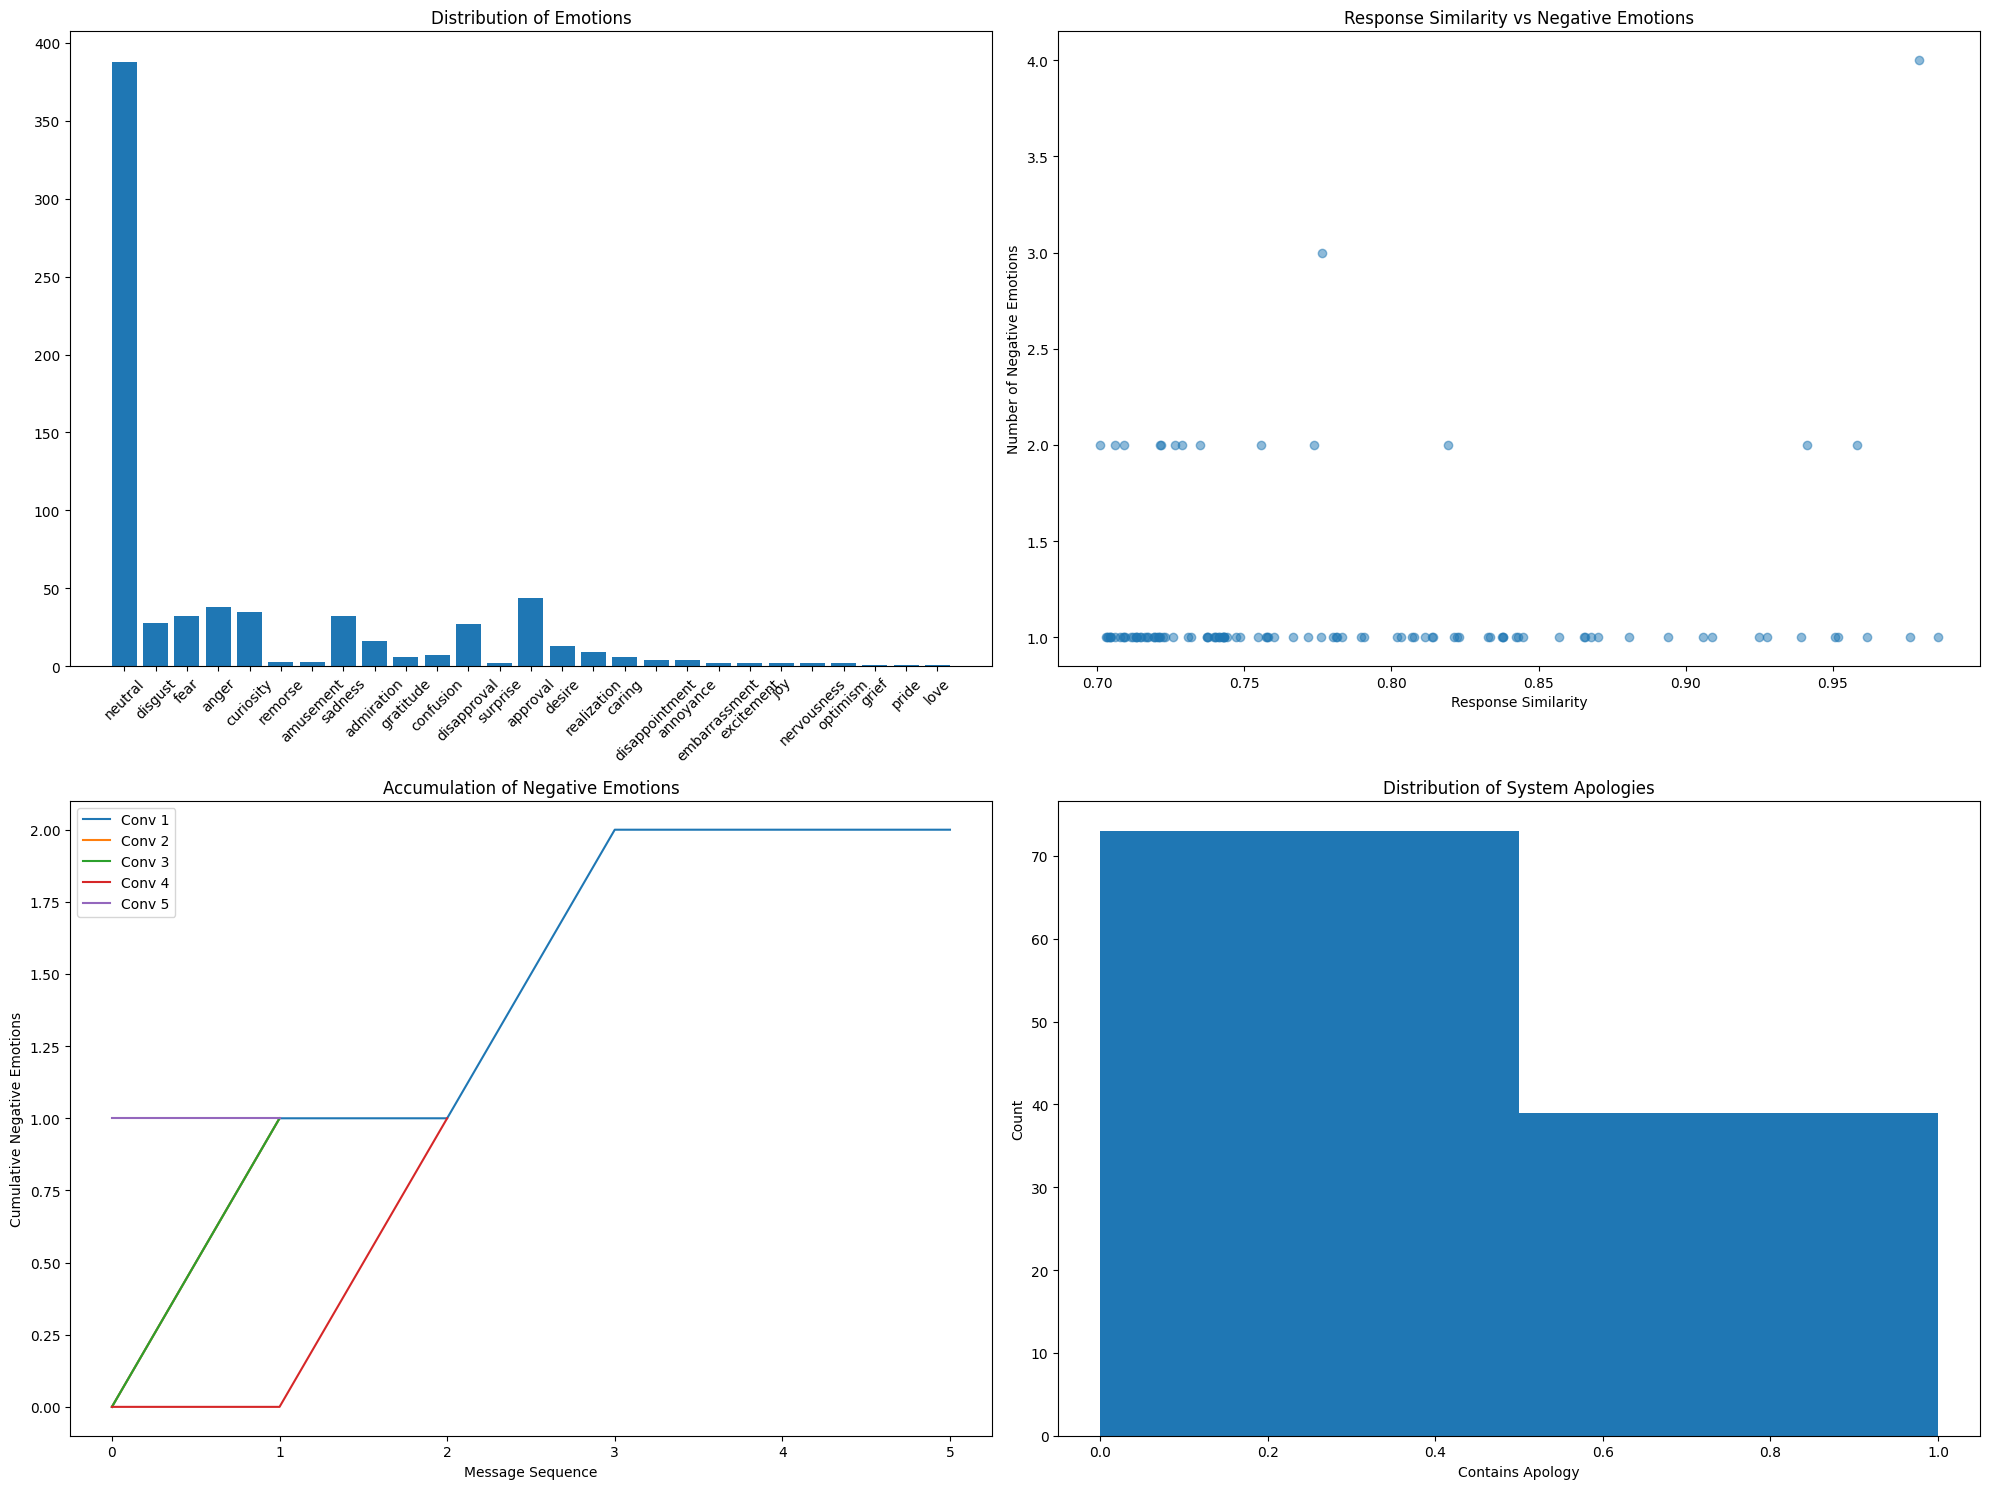


Analysis Summary:
Total conversations analyzed: 112
Conversations with apologies: 39

Emotion Distribution:
neutral: 388 (54.6%)
approval: 44 (6.2%)
anger: 38 (5.4%)
curiosity: 35 (4.9%)
fear: 32 (4.5%)
sadness: 32 (4.5%)
disgust: 28 (3.9%)
disapproval: 27 (3.8%)
admiration: 16 (2.3%)
desire: 13 (1.8%)
realization: 9 (1.3%)
confusion: 7 (1.0%)
gratitude: 6 (0.8%)
caring: 6 (0.8%)
disappointment: 4 (0.6%)
annoyance: 4 (0.6%)
remorse: 3 (0.4%)
amusement: 3 (0.4%)
surprise: 2 (0.3%)
embarrassment: 2 (0.3%)
excitement: 2 (0.3%)
joy: 2 (0.3%)
nervousness: 2 (0.3%)
optimism: 2 (0.3%)
grief: 1 (0.1%)
pride: 1 (0.1%)
love: 1 (0.1%)


In [4]:
csv_file = "/home/nipr-gpt/data/clean_src/niprgpt_msg_dyads_clean.csv"

print("Loading and processing CSV data...")
try:
    combined_df = load_and_preprocess_csv(csv_file)
    
    # Initialize the analyzer with the loaded DataFrame
    analyzer = ConversationEmotionAnalyzer(combined_df)
    
    # Analyze conversations
    print("\nAnalyzing conversations...")
    conversations = analyzer.analyze_conversations()
    
    # Generate and display report
    print("\nGenerating visualizations...")
    fig = analyzer.generate_analysis_report(conversations)
    plt.show()
    
    # Print summary statistics
    print("\nAnalysis Summary:")
    print(f"Total conversations analyzed: {len(conversations)}")
    print(f"Conversations with apologies: {sum(1 for c in conversations if c['contains_apology'])}")
    
    # Calculate and print emotion distributions
    all_emotions = []
    for conv in conversations:
        all_emotions.extend([e['emotion'] for e in conv['emotions']])
    
    emotion_dist = pd.Series(all_emotions).value_counts()
    print("\nEmotion Distribution:")
    for emotion, count in emotion_dist.items():
        print(f"{emotion}: {count} ({count/len(all_emotions)*100:.1f}%)")
    
except Exception as e:
    print(f"Error in analysis: {e}")

def analyze_conversation_domains(conversations):
    """Analyze conversations by task domain."""
    domains = {
        'technical': ['code', 'error', 'bug', 'function', 'programming'],
        'writing': ['write', 'essay', 'document', 'content', 'edit'],
        'analysis': ['analyze', 'data', 'report', 'calculate', 'metrics'],
        'explanation': ['explain', 'how', 'why', 'what is', 'mean'],
    }
    
    domain_stats = defaultdict(lambda: {'count': 0, 'emotion_patterns': [], 'apology_rate': 0})
    
    for conv in conversations:
        text = ' '.join(conv['messages'])
        domain_scores = {
            domain: sum(1 for word in words if word in text.lower())
            for domain, words in domains.items()
        }
        primary_domain = max(domain_scores.items(), key=lambda x: x[1])[0]
        
        domain_stats[primary_domain]['count'] += 1
        domain_stats[primary_domain]['emotion_patterns'].extend([e['emotion'] for e in conv['emotions']])
        domain_stats[primary_domain]['apology_rate'] += int(conv['contains_apology'])
    
    return domain_stats

def analyze_temporal_patterns(conversations, df):
    """Analyze patterns across different time periods."""
    for conv in conversations:
        conv['timestamp'] = df[df['conversation_id'] == conv['conversation_id']]['prompt_timestamp'].iloc[0]
    
    conv_df = pd.DataFrame(conversations)
    conv_df['month'] = pd.to_datetime(conv_df['timestamp']).dt.strftime('%Y-%m')
    
    monthly_stats = conv_df.groupby('month').agg({
        'negative_count': ['mean', 'max'],
        'contains_apology': 'mean',
        'response_similarity': 'mean'
    })
    
    return monthly_stats

def analyze_response_effectiveness(conversations):
    """Analyze which response patterns lead to emotion improvement."""
    response_patterns = {
        'detailed': lambda x: len(x.split()) > 100,
        'technical': lambda x: any(word in x.lower() for word in ['code', 'function', 'error']),
        'explanatory': lambda x: any(word in x.lower() for word in ['because', 'therefore', 'since']),
    }
    
    effectiveness_stats = defaultdict(lambda: {'improvement_rate': 0, 'total_occurrences': 0})
    
    for conv in conversations:
        for resp, emotions in zip(conv['responses'][:-1], zip(conv['emotions'][:-1], conv['emotions'][1:])):
            prev_emotion, next_emotion = emotions
            improvement = next_emotion['emotion'] not in ['anger', 'sadness', 'disgust', 'fear']
            
            for pattern_name, pattern_func in response_patterns.items():
                if pattern_func(resp):
                    effectiveness_stats[pattern_name]['total_occurrences'] += 1
                    effectiveness_stats[pattern_name]['improvement_rate'] += int(improvement)
    
    return effectiveness_stats

# Additional Analysis

In [8]:
# Fix timestamp parsing
for conv in conversations:
    conv['timestamp'] = combined_df[
        combined_df['conversation_id'] == conv['conversation_id']
    ]['prompt_timestamp'].iloc[0]

conv_df = pd.DataFrame(conversations)
conv_df['month'] = pd.to_datetime(conv_df['timestamp'], format='ISO8601').dt.strftime('%Y-%m')

temporal_patterns = conv_df.groupby('month').agg({
    'negative_count': ['mean', 'max'],
    'contains_apology': 'mean',
    'response_similarity': 'mean'
})

# Updated response effectiveness analysis with better type checking
def analyze_response_effectiveness(conversations):
    """Analyze which response patterns lead to emotion improvement."""
    response_patterns = {
        'detailed': lambda x: len(str(x).split()) > 100 if isinstance(x, (str, float, int)) else False,
        'technical': lambda x: any(word in str(x).lower() for word in ['code', 'function', 'error']) if isinstance(x, (str, float, int)) else False,
        'explanatory': lambda x: any(word in str(x).lower() for word in ['because', 'therefore', 'since']) if isinstance(x, (str, float, int)) else False,
    }
    
    effectiveness_stats = defaultdict(lambda: {
        'improvement_rate': 0,
        'total_occurrences': 0
    })
    
    for conv in conversations:
        for resp, emotions in zip(conv['responses'][:-1], zip(conv['emotions'][:-1], conv['emotions'][1:])):
            if resp is None or pd.isna(resp):
                continue
                
            prev_emotion, next_emotion = emotions
            improvement = next_emotion['emotion'] not in ['anger', 'sadness', 'disgust', 'fear']
            
            for pattern_name, pattern_func in response_patterns.items():
                if pattern_func(resp):
                    effectiveness_stats[pattern_name]['total_occurrences'] += 1
                    effectiveness_stats[pattern_name]['improvement_rate'] += int(improvement)
    
    return effectiveness_stats

# Recalculate response effectiveness
response_effectiveness = analyze_response_effectiveness(conversations)

# Print all results
print("\nDomain Analysis:")
for domain, stats in domain_stats.items():
    print(f"\n{domain.upper()}:")
    print(f"Count: {stats['count']}")
    print(f"Apology Rate: {stats['apology_rate']/stats['count']*100:.1f}%")

print("\nTemporal Patterns:")
print(temporal_patterns)

print("\nResponse Effectiveness:")
for pattern, stats in response_effectiveness.items():
    improvement_rate = (stats['improvement_rate'] / stats['total_occurrences'] * 100
                       if stats['total_occurrences'] > 0 else 0)
    print(f"\n{pattern}:")
    print(f"Improvement Rate: {improvement_rate:.1f}%")


Domain Analysis:

ANALYSIS:
Count: 8
Apology Rate: 25.0%

WRITING:
Count: 35
Apology Rate: 34.3%

TECHNICAL:
Count: 37
Apology Rate: 37.8%

EXPLANATION:
Count: 32
Apology Rate: 34.4%

Temporal Patterns:
        negative_count     contains_apology response_similarity
                  mean max             mean                mean
month                                                          
2024-05       1.200000   2         0.400000            0.778694
2024-06       1.083333   2         0.333333            0.755690
2024-07       1.166667   2         0.400000            0.790417
2024-08       1.166667   4         0.333333            0.784697
2024-09       1.200000   2         0.200000            0.781329

Response Effectiveness:

detailed:
Improvement Rate: 81.6%

explanatory:
Improvement Rate: 72.5%

technical:
Improvement Rate: 83.2%


# Save Results

In [12]:
import pickle
import os
import json

# Save all analysis results
save_dir = "emotion_analysis_results"
os.makedirs(save_dir, exist_ok=True)

# 1. Convert domain_stats to a regular dictionary format
serializable_domain_stats = {}
for domain, stats in domain_stats.items():
    serializable_domain_stats[domain] = {
        'count': stats['count'],
        'emotion_patterns': stats['emotion_patterns'],
        'apology_rate': stats['apology_rate']
    }

# 2. Convert temporal_patterns to a more JSON-friendly format
temporal_patterns_dict = {}
for col in temporal_patterns.columns:
    # Convert tuple column names to string
    col_name = f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col
    temporal_patterns_dict[col_name] = temporal_patterns[col].to_dict()

# 3. Save the analysis results
analysis_results = {
    'conversations': conversations,
    'conv_df': conv_df.to_dict(),
    'temporal_patterns': temporal_patterns_dict,
    'domain_stats': serializable_domain_stats,
    'response_effectiveness': dict(response_effectiveness)
}

with open(f"{save_dir}/analysis_results.pkl", "wb") as f:
    pickle.dump(analysis_results, f)
print(f"\nSaved all analysis results to {save_dir}/analysis_results.pkl")

# 4. Save summary statistics as JSON for easy viewing
summary_stats = {
    'total_conversations': len(conversations),
    'domain_summary': {
        domain: {
            'count': stats['count'],
            'apology_rate': stats['apology_rate']/stats['count']*100 if stats['count'] > 0 else 0
        }
        for domain, stats in serializable_domain_stats.items()
    },
    'temporal_patterns': temporal_patterns_dict,  # Using the converted dict
    'response_effectiveness': {
        pattern: {
            'improvement_rate': (stats['improvement_rate'] / stats['total_occurrences'] * 100
                               if stats['total_occurrences'] > 0 else 0),
            'total_occurrences': stats['total_occurrences']
        }
        for pattern, stats in response_effectiveness.items()
    }
}

with open(f"{save_dir}/summary_stats.json", 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("All results saved successfully!")


Saved all analysis results to emotion_analysis_results/analysis_results.pkl
All results saved successfully!


To load in the results...

import pickle
import json
import pandas as pd
from collections import defaultdict

# Load the saved results
save_dir = "emotion_analysis_results"

with open(f"{save_dir}/analysis_results.pkl", "rb") as f:
    analysis_results = pickle.load(f)

# Convert back to original formats
conversations = analysis_results['conversations']
conv_df = pd.DataFrame.from_dict(analysis_results['conv_df'])

# Reconstruct temporal_patterns DataFrame
temporal_patterns_dict = analysis_results['temporal_patterns']
temporal_patterns = pd.DataFrame(temporal_patterns_dict)

domain_stats = analysis_results['domain_stats']
response_effectiveness = analysis_results['response_effectiveness']

print("All results loaded successfully!")

In [2]:
if 'inference_result' in globals():
    print("Inference result exists. Length/size:", len(inference_result))
else:
    print("Inference result not found in memory.")


Inference result not found in memory.
